[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/042_cnns/cnns.ipynb)

# Redes Neuronales Convolucionales

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#import os
#os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/2-SIS421/kaggle'

In [5]:
# Reemplaza 'dataset-name' con el nombre del conjunto de datos en la URL
#!kaggle datasets download -d juniorbueno/rating-opencv-emotion-images

In [6]:
#import zipfile

#with zipfile.ZipFile('/content/rating-opencv-emotion-images.zip', 'r') as zip_ref:
 #   zip_ref.extractall('/content')

In [39]:
import os
PATH = '/content/gdrive/MyDrive/2-SIS421/1parcial/dataset/waste_images_1000perClass (1)/train'
classes = os.listdir(PATH)
classes
print(classes)

['cardboard', 'metal', 'glass', 'plastic', 'trash', 'paper', 'organic']


In [41]:
trainimgs, trainlabels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  trainimgs += [f'{PATH}/{lab}/{img}' for img in paths]
  trainlabels += [i]*len(paths)

Categoría: cardboard. Imágenes: 566
Categoría: metal. Imágenes: 632
Categoría: glass. Imágenes: 800
Categoría: plastic. Imágenes: 652
Categoría: trash. Imágenes: 538
Categoría: paper. Imágenes: 800
Categoría: organic. Imágenes: 598


In [33]:
PATH2 = '/content/gdrive/MyDrive/2-SIS421/1parcial/dataset/waste_images_1000perClass (1)/test'
classes2 = os.listdir(PATH)
classes2
print(classes2)

['cardboard', 'metal', 'glass', 'plastic', 'trash', 'paper', 'organic']


In [34]:
testimgs, testlabels = [], []

for i, lab in enumerate(classes2):
  paths = os.listdir(f'{PATH2}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  testimgs += [f'{PATH2}/{lab}/{img}' for img in paths]
  testlabels += [i]*len(paths)

Categoría: cardboard. Imágenes: 200
Categoría: metal. Imágenes: 200
Categoría: glass. Imágenes: 200
Categoría: plastic. Imágenes: 200
Categoría: trash. Imágenes: 200
Categoría: paper. Imágenes: 200
Categoría: organic. Imágenes: 200


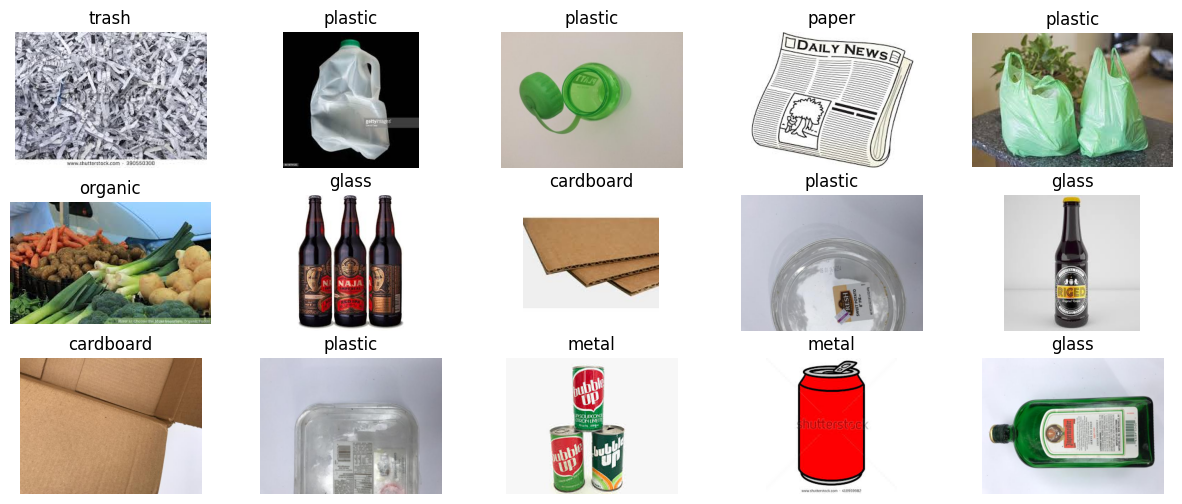

In [36]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(15,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(trainimgs)-1)
    img = io.imread(trainimgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[trainlabels[ix]])
plt.show()

In [38]:
import numpy as np
trainimgs_array = np.array(trainimgs)
trainlabels_array = np.array(trainlabels)
testimgs_array = np.array(testimgs)
testlabels_array = np.array(testlabels)
print(trainimgs_array.shape)
print(testimgs_array.shape)
print(testimgs[1])

(4586,)
(1400,)
/content/gdrive/MyDrive/2-SIS421/1parcial/dataset/waste_images_1000perClass (1)/test/cardboard/cardboard (83).jpg


In [42]:
import torch
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # Convertir la imagen a formato RGB
    rgb_img = Image.fromarray(img).convert("RGB")
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=np.array(rgb_img))["image"]
      #img = self.trans(image=img)["image"]
    #return torch.from_numpy(img / 255.).float().unsqueeze(0), torch.tensor(self.y[ix])
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [57]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224),
])

dataset = {
    'train': Dataset(trainimgs, trainlabels, trans, device),
    'test': Dataset(testimgs, testlabels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(4586, 1400)

In [15]:
#dataset['test'][5]

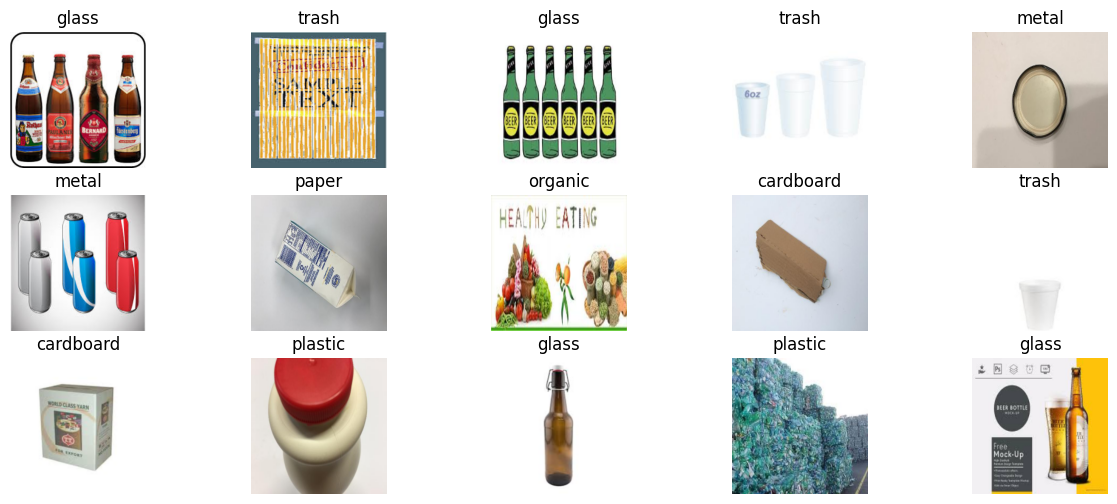

In [58]:
fig, axs = plt.subplots(3,5, figsize=(15,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['test'])-1)
    img, lab = dataset['test'][ix]
    #print(img.shape)
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes2[lab])
plt.show()

In [59]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['test']))
imgs.shape

torch.Size([256, 3, 224, 224])

## Redes Convolucionales

Una vez hemos visto los comoponentes principales de las `redes convolucionales` vamos a ver un ejemplo de cómo podemos implementar una red convolucional completa para, en este caso, la clasificación de las imágenes en el dataset MNIST. En primer lugar descargamos el dataset.

In [60]:
import torchvision

net = torchvision.models.mnasnet1_0()
net

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [61]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=7, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    net = torchvision.models.mnasnet1_0(pretrained=pretrained)
    #modificar la primera capa para un canal
    #net.features[0] = nn.Conv2d(1, 96, kernel_size=3, stride=2)
    # nos quedamos con todas las capas menos la última
    self.net = torch.nn.Sequential(*list(net.children())[:-1])
    if freeze:
      for param in self.net.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(1280*7*7, 7)

  def forward(self, x):
    x = self.net(x)
    #print(x.shape)
    x = x.view(x.shape[0], -1)
    #print(x.shape)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.net.parameters():
        param.requires_grad=True

In [62]:
model = ModelCustom()

output = model(torch.randn(64, 3, 224, 224))
print(output.shape)

torch.Size([64, 7])


Ahora, podemos entrenar la red utilizando nuestro bucle de entrenamiento.

In [63]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

Entrenando desde cero
En primer lugar vamos a entrenar nuestro modelo desde cero para ver qué métricas podemos obtener.

In [22]:
#model_c = ModelCustom()
#fit(model_c, dataloader, epochs=15)

Transfer Learning

Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de squeezenet1_0.

In [64]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader, epochs=10)

val_loss 2.16029 val_acc 0.60352: 100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


Epoch 1/10 loss 1.74804 val_loss 2.16029 acc 0.70795 val_acc 0.60352


val_loss 1.74025 val_acc 0.61888: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 2/10 loss 0.25044 val_loss 1.74025 acc 0.92175 val_acc 0.61888


val_loss 1.49722 val_acc 0.64345: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Epoch 3/10 loss 0.08341 val_loss 1.49722 acc 0.97352 val_acc 0.64345


val_loss 1.38878 val_acc 0.69253: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Epoch 4/10 loss 0.04865 val_loss 1.38878 acc 0.98708 val_acc 0.69253


val_loss 1.18864 val_acc 0.71727: 100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


Epoch 5/10 loss 0.02682 val_loss 1.18864 acc 0.99381 val_acc 0.71727


val_loss 1.21216 val_acc 0.72721: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 6/10 loss 0.02188 val_loss 1.21216 acc 0.99631 val_acc 0.72721


val_loss 1.18743 val_acc 0.72769: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Epoch 7/10 loss 0.01634 val_loss 1.18743 acc 0.99783 val_acc 0.72769


val_loss 1.26457 val_acc 0.71775: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Epoch 8/10 loss 0.01344 val_loss 1.26457 acc 0.99913 val_acc 0.71775


val_loss 1.14230 val_acc 0.73885: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Epoch 9/10 loss 0.01582 val_loss 1.14230 acc 0.99805 val_acc 0.73885


val_loss 0.99589 val_acc 0.75907: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

Epoch 10/10 loss 0.01017 val_loss 0.99589 acc 0.99902 val_acc 0.75907


Fine Tuning
Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en squeezenet1_0., entrenamos también la red completa.

In [65]:
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader,epochs=10)

val_loss 1.94789 val_acc 0.56905: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


Epoch 1/10 loss 1.67752 val_loss 1.94789 acc 0.71688 val_acc 0.56905


val_loss 1.83536 val_acc 0.59813: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Epoch 2/10 loss 0.18156 val_loss 1.83536 acc 0.94030 val_acc 0.59813


val_loss 1.79140 val_acc 0.61979: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Epoch 3/10 loss 0.05538 val_loss 1.79140 acc 0.98274 val_acc 0.61979


val_loss 1.64590 val_acc 0.64449: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 4/10 loss 0.02860 val_loss 1.64590 acc 0.99436 val_acc 0.64449


val_loss 1.60617 val_acc 0.66272: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


Epoch 5/10 loss 0.01836 val_loss 1.60617 acc 0.99805 val_acc 0.66272


val_loss 1.61640 val_acc 0.65278: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 6/10 loss 0.01331 val_loss 1.61640 acc 0.99913 val_acc 0.65278


val_loss 1.73518 val_acc 0.64518: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 7/10 loss 0.01240 val_loss 1.73518 acc 0.99826 val_acc 0.64518


val_loss 1.51930 val_acc 0.68064: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Epoch 8/10 loss 0.01146 val_loss 1.51930 acc 0.99870 val_acc 0.68064


val_loss 1.52190 val_acc 0.67812: 100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


Epoch 9/10 loss 0.00842 val_loss 1.52190 acc 0.99935 val_acc 0.67812


val_loss 1.58996 val_acc 0.66549: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]

Epoch 10/10 loss 0.00761 val_loss 1.58996 acc 0.99957 val_acc 0.66549


In [70]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader)
model_o.unfreeze()
fit(model_o, dataloader,epochs=10, lr=1e-3)

val_loss 2.64550 val_acc 0.54054: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Epoch 1/5 loss 2.27940 val_loss 2.64550 acc 0.69700 val_acc 0.54054


val_loss 1.34205 val_acc 0.71085: 100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


Epoch 2/5 loss 0.28226 val_loss 1.34205 acc 0.91709 val_acc 0.71085


val_loss 2.02161 val_acc 0.61389: 100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


Epoch 3/5 loss 0.09584 val_loss 2.02161 acc 0.96744 val_acc 0.61389


val_loss 1.59263 val_acc 0.65807: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 4/5 loss 0.04319 val_loss 1.59263 acc 0.98773 val_acc 0.65807


val_loss 1.44904 val_acc 0.68429: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Epoch 5/5 loss 0.02950 val_loss 1.44904 acc 0.99349 val_acc 0.68429


val_loss 1.40628 val_acc 0.69349: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 1/10 loss 0.01688 val_loss 1.40628 acc 0.99740 val_acc 0.69349


val_loss 1.41455 val_acc 0.69748: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Epoch 2/10 loss 0.01253 val_loss 1.41455 acc 0.99891 val_acc 0.69748


val_loss 1.43839 val_acc 0.69340: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Epoch 3/10 loss 0.01687 val_loss 1.43839 acc 0.99694 val_acc 0.69340


val_loss 1.39022 val_acc 0.70473: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 4/10 loss 0.01388 val_loss 1.39022 acc 0.99805 val_acc 0.70473


val_loss 1.33985 val_acc 0.71272: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Epoch 5/10 loss 0.01372 val_loss 1.33985 acc 0.99826 val_acc 0.71272


val_loss 1.33194 val_acc 0.71892: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Epoch 6/10 loss 0.01324 val_loss 1.33194 acc 0.99891 val_acc 0.71892


val_loss 1.28508 val_acc 0.72569: 100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


Epoch 7/10 loss 0.01152 val_loss 1.28508 acc 0.99935 val_acc 0.72569


val_loss 1.28128 val_acc 0.72244: 100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


Epoch 8/10 loss 0.01218 val_loss 1.28128 acc 0.99826 val_acc 0.72244


val_loss 1.25619 val_acc 0.73229: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Epoch 9/10 loss 0.01210 val_loss 1.25619 acc 0.99880 val_acc 0.73229


val_loss 1.22344 val_acc 0.73711: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]

Epoch 10/10 loss 0.01180 val_loss 1.22344 acc 0.99891 val_acc 0.73711


In [71]:
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, r, c):
    model.to('cuda')
    model.eval()
    with torch.no_grad():
        for loader_name, test_loader in dataloader.items():
            if loader_name == 'test':
                continue
            # Mostrar las primeras imágenes del primer lote del DataLoader de prueba
            fig = plt.figure(figsize=(2*c, 2*r))
            for batch_idx, (data, target) in enumerate(test_loader):
                if batch_idx == 0:
                    data = data.to('cuda')
                    target = target.to('cuda')
                    output = model(data)
                    predictions = output.argmax(dim=1)
                    for i in range(r * c):
                        plt.subplot(r, c, i + 1)
                        img = data[i].cpu().numpy().transpose(1, 2, 0)
                        y_true = target[i].item()
                        y_pred = predictions[i].item()
                        plt.imshow(img, cmap='gray')
                        plt.axis("off")
                        #plt.title(f"{y_true}/{y_pred}", color="green" if y_true == y_pred else "red")
                        plt.title(f"{classes[y_true]}/{classes[y_pred]}", color="green" if y_true == y_pred else "red")
                        plt.tight_layout()
                    plt.show()
                    break

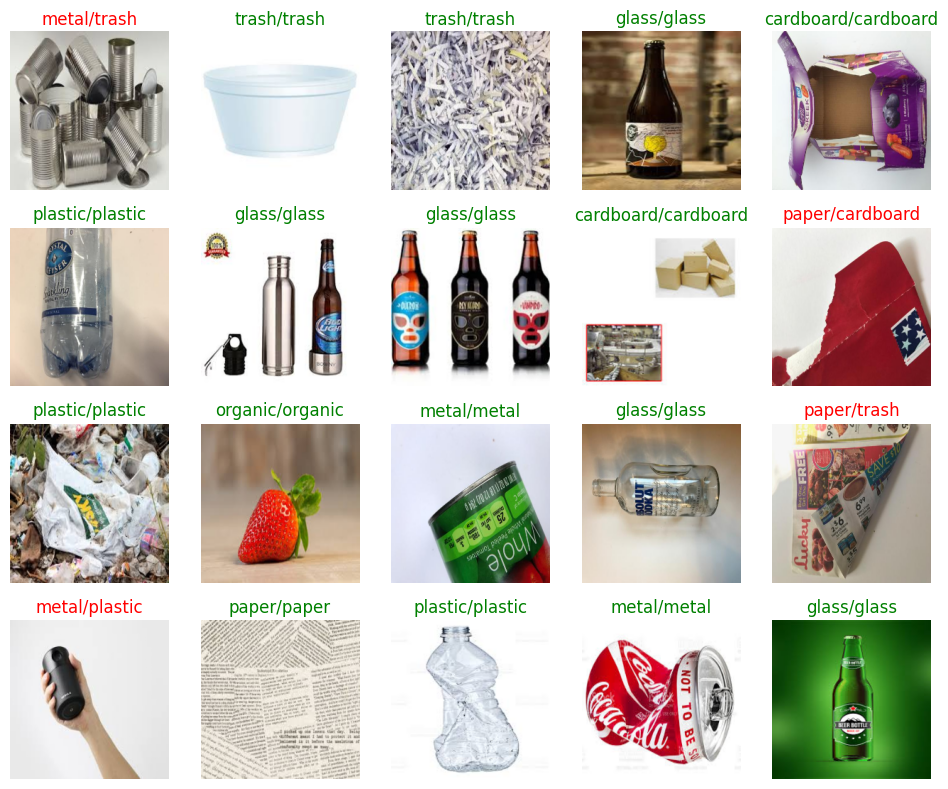

In [72]:
plot_predictions(model_o, dataloader,4,5)

Eleji un data set de el cual es de 28709 imagenes de entrenamiento y 3589 de validacion o prueba  estas imagenes son de 48x48,
eleji el modelo pre entrenado squeezenet1_0 que se destaca por su tamaño reducido y eficiencia, lo que lo hace adecuado para aplicaciones con restricciones computacionales. A pesar de su tamaño compacto, logra mantener un buen rendimiento en tareas de clasificación.


Bueno segun mis resultado para 5 epochs llego hasta un 50% de precision con los imagenes de prueba , al aumentar los epochs a 10 obtube una precision de 62.8% con las imagenes de prueba pero con los de entrenamiento es del 63.2%  , estos resultados pueden mejorar aunmentando los epochs

## Resumen

En este post hemos introducido la arquitectura de `red neuronal` conocida como `red neuronal convolucional`. Este tipo de redes, inspiradas en el funcionamiento del córtex visual, están especialmente diseñadas para trabajar con imágenes. Gracias a la aplicación de la `capa convolucional`, la red será capaz de reconocer diferentes formas, colores y texturas que, de manera jerárquica, irá componiendo en estructuras cada vez más complejas para poder llevar a cabo su tarea de la mejor forma posible. En futuros posts hablaremos sobre diferente arquitecturas de CNN que han aparecido durante los últimos años y que podemos utilizar para nuestras aplicaciones.